# **Predict HDB resale price**

### Predict hdb resale price using LightGBM model

LightGBM builds a model that can make accurate predictions, even with large and complex data using the following features

- Decision Trees: These are like flowcharts that make decisions based on conditions. For example, "If the house is big, then it's expensive."
- Gradient Boosting: This is the process of building the house tree by tree, learning from the mistakes of the previous ones.
- Light: This means the model is efficient and fast. It can build the house quickly, even with a lot of rooms.

## Pre-Modelling

We will be importing the necessary modules to train the models

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [2]:
# Loading Train Data
df_train = pd.read_csv('train_ce.csv', low_memory=False)

Merging train data with macroeconomic data from HDB dataset (Population, Resident Population, etc)
- to improve the RMSE

In [3]:
# reading csv 
df_constructed = pd.read_csv('pop_cons_merged.csv')
df_train_merge = pd.merge(df_train, df_constructed, left_on='Tranc_Year', right_on='Year', how='left')

These columns are seem unecessary and and repetitive to other columns inputs, hence we decided to drop the column

In [4]:
df_train_final = df_train_merge.drop(columns=['lease_commence_date', 'year_completed','postal', 'Latitude', 'Longitude','mrt_latitude', 'mrt_longitude',
    'pri_sch_latitude', 'pri_sch_longitude','flat_type','flat_model','town','storey_range','storey_ratio','mrt_name',
    'vacancy','sec_sch_latitude', 'sec_sch_longitude','bus_stop_latitude', 'bus_stop_longitude','storey_high_mid_low','Year','cutoff_point'])

In [5]:
# Formating the datetime format to Year and Month
df_train_final['Tranc_YearMonth'] = pd.to_datetime(df_train_final['Tranc_YearMonth'], format='%Y-%m')

In [6]:
# Loading data test set
df_test = pd.read_csv('test_ce.csv',low_memory=False)

Merging train data with macroeconomic data from hdb dataset (Population, Resident Populaion etc)
- to improve the RMSE

In [7]:
df_test_merge = pd.merge(df_test, df_constructed, left_on='Tranc_Year', right_on='Year', how='left')

these columns were drop for the final test dataset as it was seen as unecessary or it is repetitive of other column names

In [8]:
df_test_final = df_test_merge.drop(columns=['lease_commence_date', 'year_completed','postal', 'Latitude', 'Longitude','mrt_latitude', 'mrt_longitude',
    'pri_sch_latitude', 'pri_sch_longitude','flat_type','flat_model','town','storey_range','storey_ratio','mrt_name',
    'vacancy','sec_sch_latitude', 'sec_sch_longitude','bus_stop_latitude', 'bus_stop_longitude','storey_high_mid_low','Year','cutoff_point'])

In [9]:
# Converting the date time Year & Month
df_test_final['Tranc_YearMonth'] = pd.to_datetime(df_test_final['Tranc_YearMonth'], format='%Y-%m')
df_test_final.info()
df_test_final.to_csv('df_test_final.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 40 columns):
 #   Column                                                                      Non-Null Count  Dtype         
---  ------                                                                      --------------  -----         
 0   Tranc_YearMonth                                                             16737 non-null  datetime64[ns]
 1   resale_price                                                                16737 non-null  float64       
 2   Tranc_Year                                                                  16737 non-null  int64         
 3   Tranc_Month                                                                 16737 non-null  int64         
 4   floor_area_sqft                                                             16737 non-null  float64       
 5   hdb_age                                                                     16737 non-null  int64     

These selected variables are narrowed down from the 70+ variables are selected base on
- Importancy of the variables that will make the business decisions
- Feature engineered variables that will derive impact and importancy to the agents and end users
  

In [10]:
# Selecting the variables used in the model
selected_variables = [
    'Tranc_Year', 'Tranc_Month', 'floor_area_sqft', 'flat_type_Encoded', 'max_floor_lvl',
    'storey_high_mid_low_Encoded', 'hdb_age', 'town_Encoded', 'mrt_name_Encoded',
    'mrt_nearest_distance', 'Mall_Nearest_Distance',
    'Hawker_Nearest_Distance', 'Hawker_Within_1km_boolean', 'hawker_food_stalls',
    'hawker_market_stalls', 'pri_sch_name_Encoded', 'pri_sch_nearest_distance',
    'pri_sch_pop_Encoded', 'sec_sch_name_Encoded', 'sec_sch_nearest_dist',
    'Total Population', 'Permanent Resident Population (Number)',
    'Non-Resident Population (Number)', 'Singapore Citizen Population (Number)','BTO completed'
]

# Count the number of selected variables
num_selected_variables = len(selected_variables)

# Print the outcome of the variable
print(f'The number of selected variables is: {num_selected_variables}')

The number of selected variables is: 25


In [11]:
# Define Target Variable
target_variable = 'resale_price'

In [39]:
# Training data with 25 selected variable against resale price
X_train = df_train_final[selected_variables]
y_train = df_train_final[target_variable]

NameError: name 'df_train_final' is not defined

In [13]:
# x test against 25 selected variables
X_test = df_test_final[selected_variables]
# y test against resale prices
y_test = df_test_final[target_variable]

In [14]:
# Initializing and train the LightGBM model with the selected variable
model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train) 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 150634, number of used features: 25
[LightGBM] [Info] Start training from score 449161.501212


LGBMRegressor(random_state=42)

5-fold cross-validation is a technique used in machine learning to evaluate the performance of a model. It helps prevent overfitting
- Data is then divided into 5 equal parts to train
- Training the model on four parts and testing on the remaining part
- Process is repeated five times, each time using a different part for testing

In [15]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
# -Print the average score across the 5 folds
print(f"Average CV score: {cv_scores.mean()}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 120507, number of used features: 25
[LightGBM] [Info] Start training from score 448851.843961
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 120507, number of used features: 25
[LightGBM] [Info] Start training from score 448821.289430
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ov

In [16]:
# model is fitted on the full dataset to be train and evaluated
model.fit(X_train, y_train, eval_set=(X_test, y_test))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 150634, number of used features: 25
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 449161.501212


LGBMRegressor(random_state=42)

In [41]:
# Training data with 25 selected variable against resale price
y_train_pred = model.predict(X_train)

NameError: name 'model' is not defined

In [18]:
# Calculating RMSE for the Training Data
rmse_train = root_mean_squared_error(y_train, y_train_pred)
print(f'Training RMSE: {rmse_train}')

Training RMSE: 30969.443942355774


In [19]:
# model is fitted on the full dataset to be train and evaluated
y_pred = model.predict(X_test)

In [20]:
# Calculate the RMSE for Test 
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 31786.772675928976


In [21]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': selected_variables,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Print sorted feature importances
print(feature_importance_df)

                                   Feature  Importance
7                             town_Encoded         321
6                                  hdb_age         315
2                          floor_area_sqft         306
13                      hawker_food_stalls         242
4                            max_floor_lvl         241
9                     mrt_nearest_distance         205
11                 Hawker_Nearest_Distance         194
8                         mrt_name_Encoded         161
14                    hawker_market_stalls         137
10                   Mall_Nearest_Distance         132
15                    pri_sch_name_Encoded         122
18                    sec_sch_name_Encoded         106
0                               Tranc_Year         106
5              storey_high_mid_low_Encoded          72
3                        flat_type_Encoded          71
20                        Total Population          69
19                    sec_sch_nearest_dist          68
16        

Plot Feature Importance

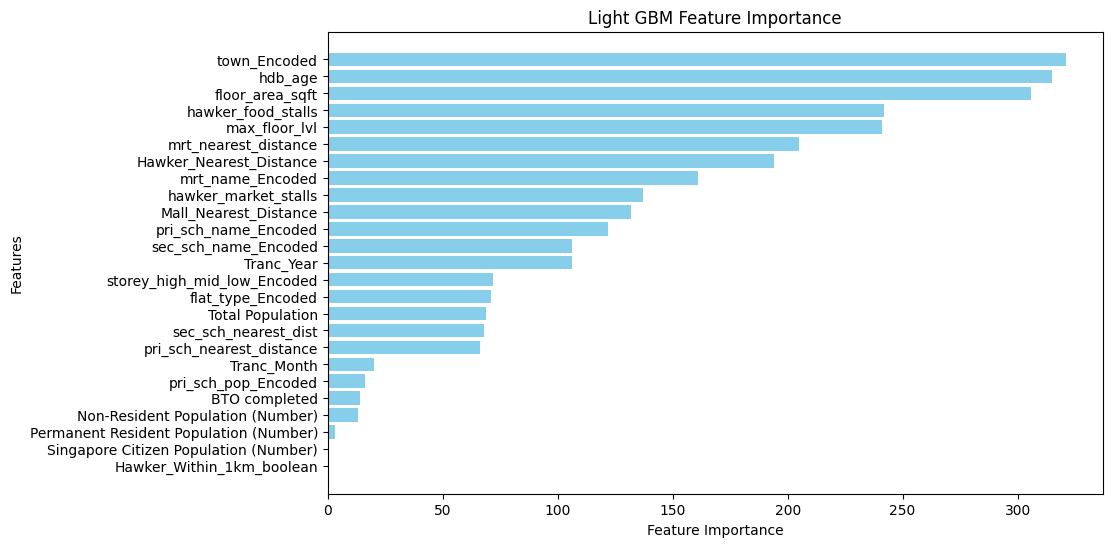

In [22]:
feature_importances = model.feature_importances_
features_sorted = sorted(zip(feature_importances, selected_variables), reverse=True)
sorted_importances, sorted_features = zip(*features_sorted)

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Light GBM Feature Importance')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

In [23]:
#  Calculate the R² score
#  Convert R² to a percentage
r2 = r2_score(y_test, y_pred)
accuracy_percentage = r2 * 100
print(f"Model accuracy (R²): {accuracy_percentage:.2f}%")

Model accuracy (R²): 95.07%


In [24]:
# Save predictions to a CSV file
df_test['Predicted_Values'] = y_pred
df_test.to_csv('df_test_with_lightgbm_predictions_rf.csv', index=False)